**Actividad Acreditable N° 3**
# Trabajo Práctico Aplicación Práctica

Objetivos:

Este trabajo práctico tiene como objetivo aplicar conocimientos en programación y estadística para desarrollar un modelo de regresión que prediga ventas de videojuegos basándose en el dataset "vgsales.csv".

Para comenzar con la primera parte de este proyecto, que implica el análisis exploratorio de datos (EDA), necesitamos seguir estos pasos:

- Cargar los Datos: Importaremos el conjunto de datos utilizando pandas.
- Inspeccionar los Datos: Observaremos las primeras filas del conjunto de datos para entender la estructura y el tipo de datos que tenemos.
- Resumen Estadístico: Obtendremos un resumen estadístico de los datos, lo que incluye medidas como el promedio, mediana, rango, etc.
- Verificar Valores Faltantes: Identificaremos si hay valores faltantes en el conjunto de datos.
- Análisis de Distribuciones y Tendencias: Analizaremos la distribución de las variables numéricas y las tendencias en los datos, como las ventas a lo largo del tiempo y la popularidad de diferentes géneros o plataformas.

In [39]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Cargar los datos
file_path = 'vgsales.csv'
data = pd.read_csv(file_path)

# Inspeccionar las primeras filas del conjunto de datos
data.head()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


- Rank: Es un identificador numérico que parece ordenar los juegos según las ventas totales.
- Name: El nombre del juego.
- Platform: La plataforma en la que se lanzó el juego (por ejemplo, Wii, NES, etc.).
- Year: Año de lanzamiento del juego.
- Genre: Género del juego.
- Publisher: Editor del juego.
- NA_Sales, EU_Sales, JP_Sales, Other_Sales: Ventas en distintas regiones del mundo (América del Norte, Europa, Japón, otros), en millones.
- Global_Sales: Ventas mundiales totales, también en millones.

In [40]:
# Resumen estadístico
summary_statistics = data.describe()

# Verificar tipos de datos
data_types = data.dtypes

# Verificar valores faltantes
missing_values = data.isnull().sum()

summary_statistics, data_types, missing_values


(               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
 count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
 mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
 std     4791.853933      5.828981      0.816683      0.505351      0.309291   
 min        1.000000   1980.000000      0.000000      0.000000      0.000000   
 25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
 50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
 75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
 max    16600.000000   2020.000000     41.490000     29.020000     10.220000   
 
         Other_Sales  Global_Sales  
 count  16598.000000  16598.000000  
 mean       0.048063      0.537441  
 std        0.188588      1.555028  
 min        0.000000      0.010000  
 25%        0.000000      0.060000  
 50%        0.010000      0.170000  
 75%        0.04000

**Resumen Estadístico**

Las ventas varían significativamente, con un rango que va desde un mínimo de 0 (probablemente indicando juegos con ventas muy bajas) hasta un máximo de 41.49 millones en NA_Sales.
La media y la mediana (50%) de las ventas en cada región muestran una distribución sesgada, donde unos pocos juegos tienen ventas muy altas.
El año de los juegos varía desde 1980 hasta 2020, lo que nos da una amplia cronología de la industria de los videojuegos.
Tipos de Datos
La mayoría de las columnas son del tipo esperado. Sin embargo, el año está en formato flotante, lo que podría no ser ideal para análisis temporales.
Valores Faltantes
Hay 271 valores faltantes en la columna Year y 58 en la columna Publisher.

# Paso 1: Limpieza de Datos
Tratar valores faltantes:

Para la columna Year, podríamos considerar imputar los valores faltantes con el año más frecuente o eliminar esas filas.

Para la columna Publisher, podríamos eliminar las filas con valores faltantes o imputarlas con un valor como 'Unknown'.
Ajustar tipos de datos:

Convertiremos la columna Year a tipo entero.

In [41]:
# Eliminar filas donde 'Year' o 'Publisher' es nulo
data_cleaned = data.dropna(subset=['Year', 'Publisher'])

# Convertir 'Year' a entero
data_cleaned['Year'] = data_cleaned['Year'].astype(int)

# Verificación
print(data_cleaned.isnull().sum())
print(data_cleaned.dtypes)


Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64
Rank              int64
Name             object
Platform         object
Year              int32
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


Tratamiento de Valores Atípicos (Outliers)

Los valores atípicos pueden ser problemáticos ya que pueden afectar la precisión de los modelos de regresión. Hay varias formas de tratar con ellos, pero un enfoque común es eliminar aquellos datos que caen fuera de un rango intercuartilico (IQR).

In [42]:
# Definir una función para detectar outliers
def detect_outliers_iqr(df, features):
    outlier_indices = []
    
    for c in features:
        # Calcular el IQR
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calcular el umbral de outlier
        outlier_step = 1.5 * IQR
        
        # Determinar los índices de los outliers
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        
        # Agregar los índices al conjunto de outliers
        outlier_indices.extend(outlier_list_col)
    
    # Seleccionar observaciones con más de una característica atípica
    outlier_indices = list(set(outlier_indices))
    return outlier_indices

# Detectar outliers en las columnas de ventas
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
outliers_to_remove = detect_outliers_iqr(data_cleaned, sales_columns)

# Eliminar los outliers
data_no_outliers = data_cleaned.drop(outliers_to_remove, axis=0).reset_index(drop=True)


# Paso 2: Exploración Adicional de Datos
Análisis de Ventas por Región:

Podemos graficar las distribuciones de ventas por región.
Exploración de Géneros y Plataformas:

Analizaremos la popularidad de diferentes géneros y plataformas.

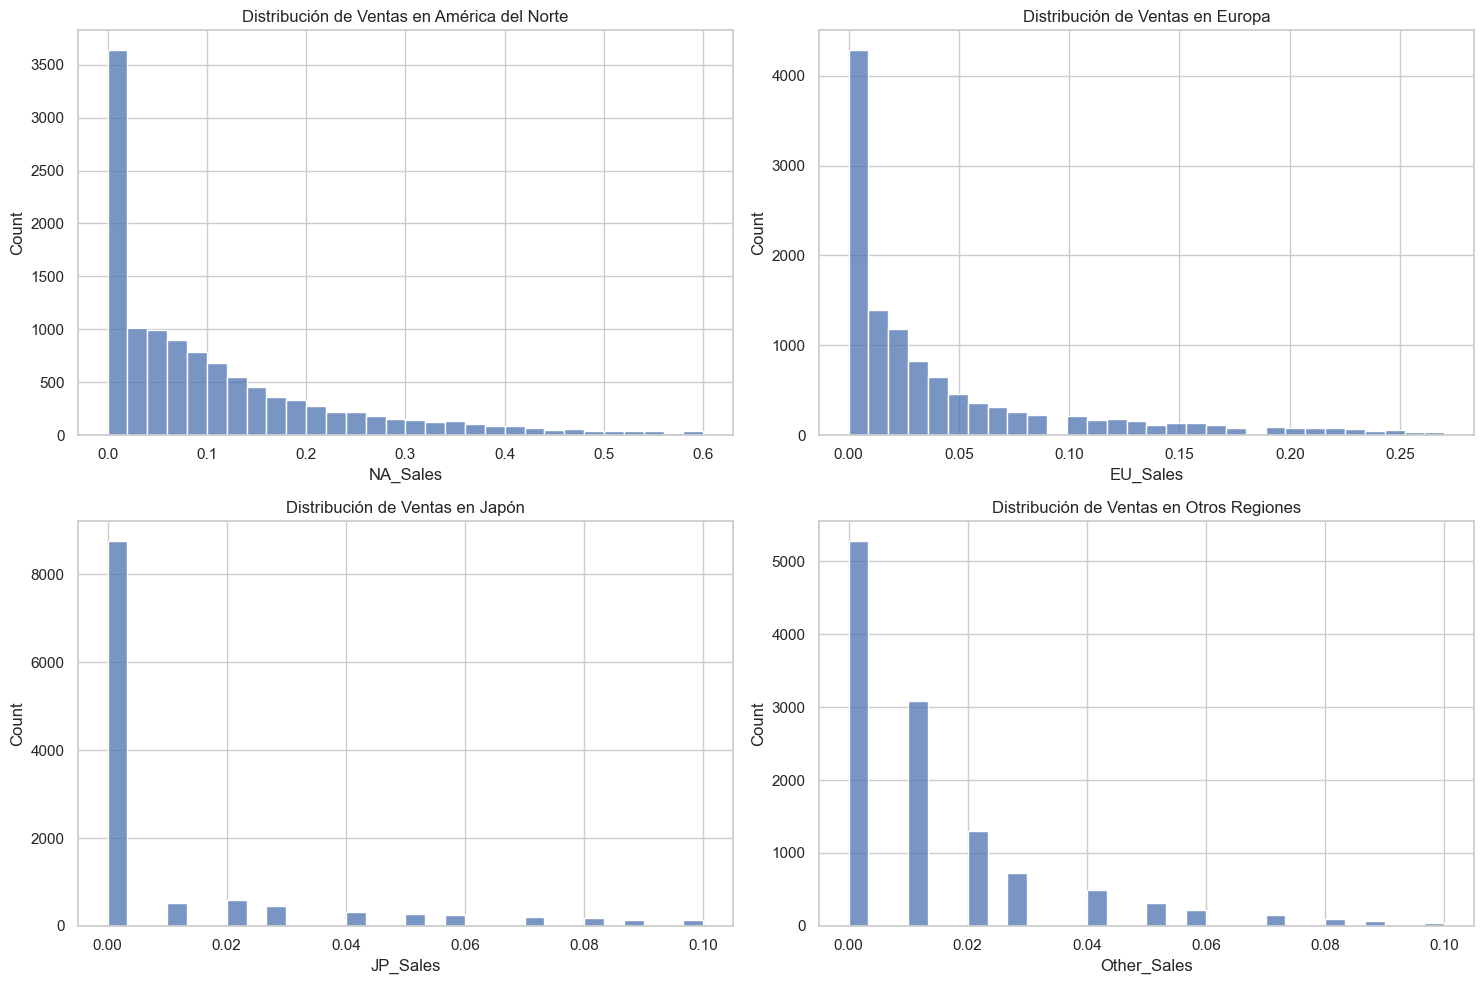

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de Seaborn
sns.set(style="whitegrid")

# Gráfico de distribución de ventas por región
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.histplot(data_no_outliers['NA_Sales'], kde=False, bins=30)
plt.title('Distribución de Ventas en América del Norte')
plt.subplot(2,2,2)
sns.histplot(data_no_outliers['EU_Sales'], kde=False, bins=30)
plt.title('Distribución de Ventas en Europa')
plt.subplot(2,2,3)
sns.histplot(data_no_outliers['JP_Sales'], kde=False, bins=30)
plt.title('Distribución de Ventas en Japón')
plt.subplot(2,2,4)
sns.histplot(data_no_outliers['Other_Sales'], kde=False, bins=30)
plt.title('Distribución de Ventas en Otros Regiones')
plt.tight_layout()
plt.show()



Distribución de Ventas por Región

Este conjunto de gráficos muestra la distribución de las ventas de videojuegos en las cuatro principales regiones de venta: América del Norte, Europa, Japón y otras regiones. Cada gráfico muestra una distribución sesgada a la derecha, lo que indica que la mayoría de los videojuegos venden relativamente pocas copias, mientras que unos pocos títulos logran altas ventas. Esta es una distribución típica en muchas industrias creativas, donde unos pocos éxitos dominan el mercado.

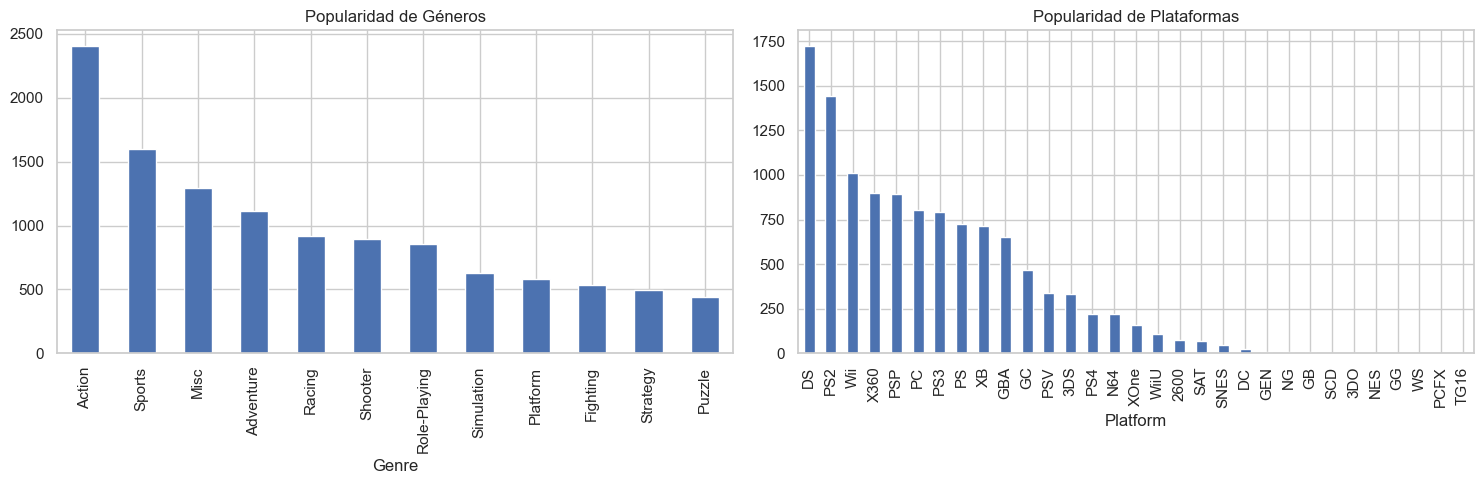

In [44]:
# Análisis de Géneros y Plataformas
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
data_no_outliers['Genre'].value_counts().plot(kind='bar')
plt.title('Popularidad de Géneros')
plt.subplot(1,2,2)
data_no_outliers['Platform'].value_counts().plot(kind='bar')
plt.title('Popularidad de Plataformas')
plt.tight_layout()
plt.show()


Popularidad de Géneros y Plataformas

Estos gráficos proporcionan una comparación visual del número de títulos lanzados por género y por plataforma. El primer gráfico destaca que el género 'Action' es el más popular, seguido de 'Sports' y 'Misc'. El segundo gráfico muestra que la plataforma 'DS' tiene el mayor número de títulos lanzados, seguida por 'PS2'. Estos datos pueden reflejar las preferencias del mercado y las estrategias de producción de las editoras de videojuegos.

Análisis de Ventas por Género y Plataforma:
Para entender mejor cómo las ventas globales varían con el género y la plataforma, podemos crear gráficos de barras que muestren las ventas globales medias para cada género y plataforma.

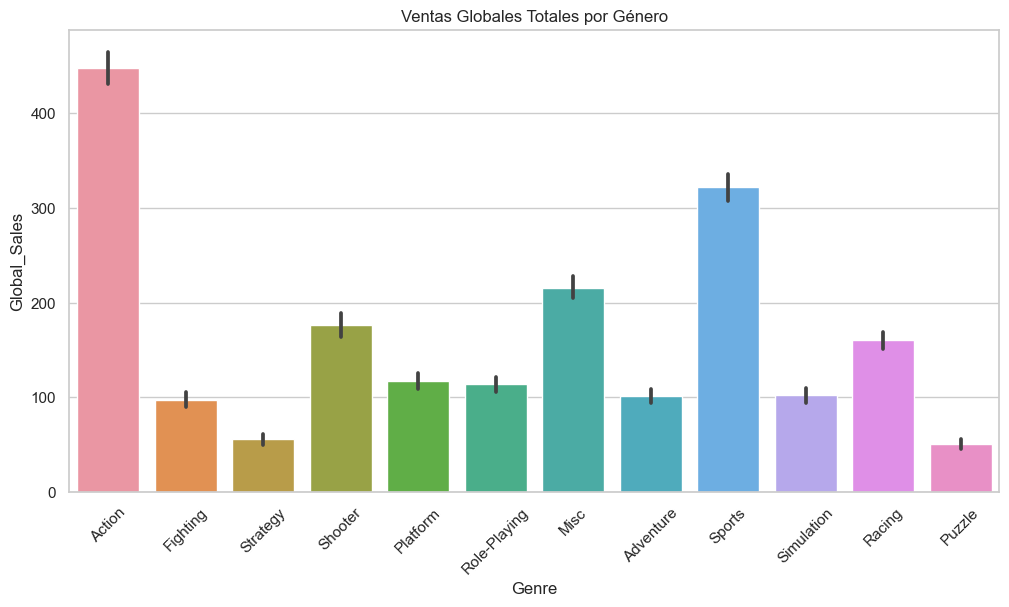

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")

# Ventas globales medias por Género
plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='Global_Sales', data=data_no_outliers, estimator=sum)
plt.title('Ventas Globales Totales por Género')
plt.xticks(rotation=45)
plt.show()



Ventas Globales Totales por Género

Este gráfico de barras muestra las ventas globales totales por género. Se observa que los géneros 'Action' y 'Sports' no solo tienen muchos títulos, sino que también generan las mayores ventas globales totales, lo que sugiere que son géneros muy rentables.

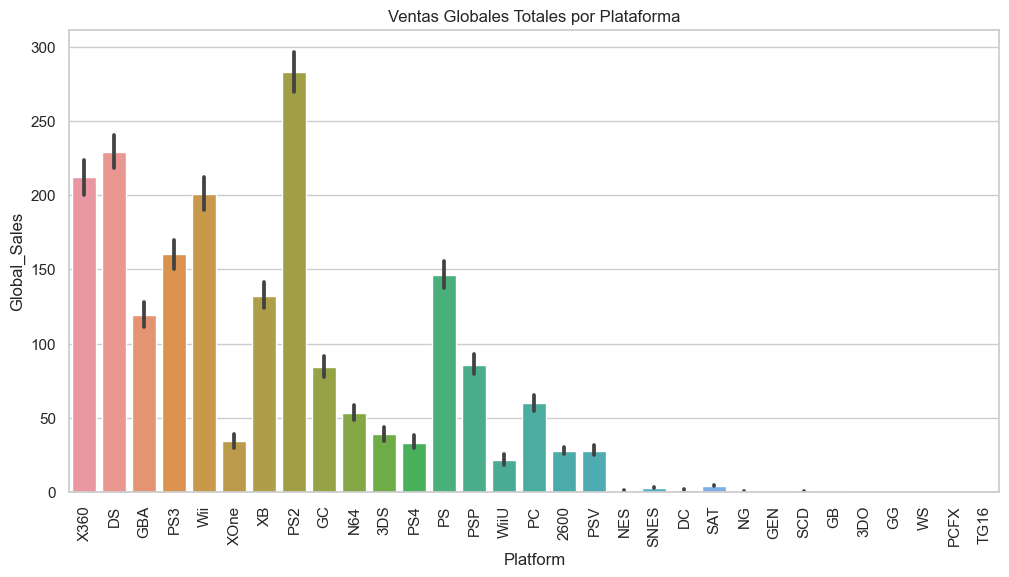

In [46]:

# Ventas globales medias por Plataforma
plt.figure(figsize=(12, 6))
sns.barplot(x='Platform', y='Global_Sales', data=data_no_outliers, estimator=sum)
plt.title('Ventas Globales Totales por Plataforma')
plt.xticks(rotation=90)
plt.show()

Ventas Globales Totales por Plataforma

Similar al gráfico por género, este muestra las ventas globales totales por plataforma, destacando cuáles han generado más ingresos. Las plataformas 'PS2' y 'DS' lideran en ventas, lo que podría estar relacionado con su popularidad y la base instalada de usuarios.

Análisis de Tendencias Temporales en las Ventas:
Para observar las tendencias a lo largo de los años, podemos hacer un gráfico de líneas de las ventas globales totales por año.

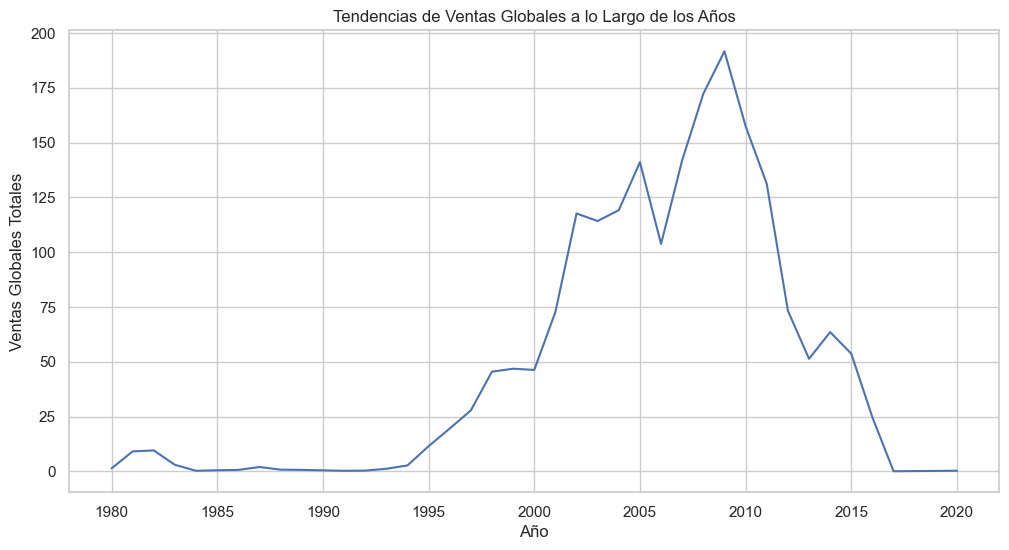

In [47]:
plt.figure(figsize=(12, 6))
sales_by_year = data_no_outliers.groupby('Year')['Global_Sales'].sum()
sales_by_year.plot(kind='line')
plt.title('Tendencias de Ventas Globales a lo Largo de los Años')
plt.xlabel('Año')
plt.ylabel('Ventas Globales Totales')
plt.show()


Tendencias de Ventas Globales a lo Largo de los Años

Este gráfico de líneas ilustra cómo han cambiado las ventas globales de videojuegos a lo largo de los años. Se observa un pico alrededor de 2008, lo que podría reflejar la popularidad de ciertas consolas o títulos en ese momento.

Mapa de Calor de Correlación:
Un mapa de calor nos ayudará a entender la relación entre diferentes variables, especialmente las ventas en diferentes regiones y las ventas globales.

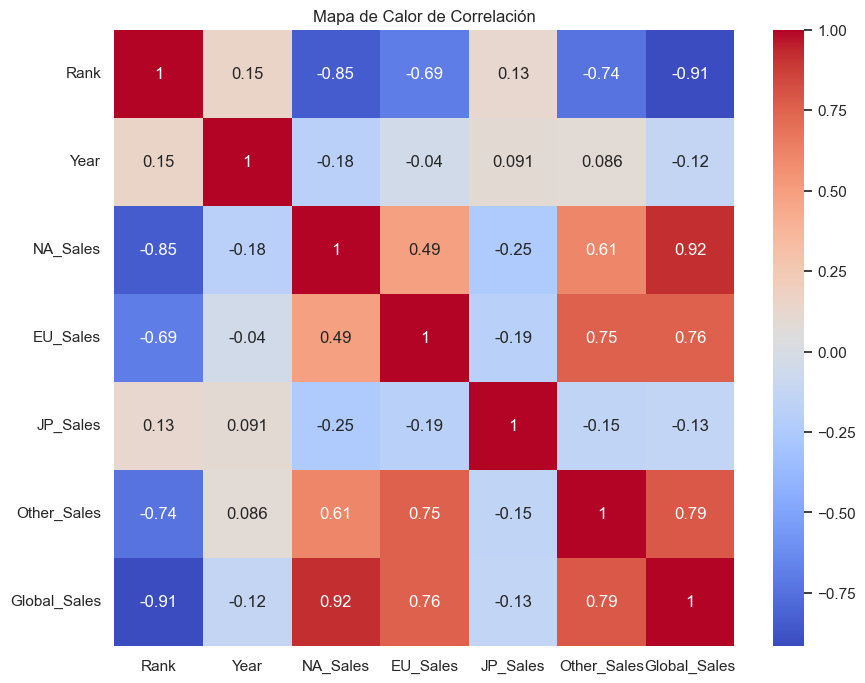

In [48]:
# Seleccionar solo las columnas numéricas para la correlación
numeric_data = data_no_outliers.select_dtypes(include=[np.number])

# Calcular la matriz de correlación solo con datos numéricos
correlation_matrix = numeric_data.corr()

# Dibujar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')
plt.show()


Mapa de Calor de Correlación

El mapa de calor muestra las correlaciones entre las diferentes variables de ventas y el ranking de los juegos. Las fuertes correlaciones negativas entre 'Rank' y 'Global_Sales' indican que los juegos con un rango de ventas más bajo (es decir, más vendidos) tienen mayores ventas globales. Las correlaciones positivas entre las ventas en diferentes regiones y las ventas globales reflejan que las ventas en una región son buenos predictores de las ventas globales.

# Paso 3: Selección de Características Relevantes

Para la creación de un modelo de regresión, debemos seleccionar características (features) que influyen en la variable objetivo. En este caso, si estamos interesados en predecir las Global_Sales, podemos considerar características como Platform, Year, Genre, Publisher, y las ventas regionales (NA_Sales, EU_Sales, JP_Sales, Other_Sales) como predictores.

In [49]:
# Seleccionamos solo las columnas numéricas para la correlación
numeric_cols = data_no_outliers.select_dtypes(include=['number']).columns

# Calculamos la correlación solo con datos numéricos
correlation_with_target = data_no_outliers[numeric_cols].corr()['Global_Sales'].sort_values(ascending=False)

# Seleccionamos características con una correlación significativa
significant_features = correlation_with_target[abs(correlation_with_target) > 0.1].index.tolist()

# Removemos la variable objetivo de la lista de características significativas
significant_features.remove('Global_Sales')

print("Características seleccionadas basadas en la correlación con las ventas globales:")
print(significant_features)


Características seleccionadas basadas en la correlación con las ventas globales:
['NA_Sales', 'Other_Sales', 'EU_Sales', 'Year', 'JP_Sales', 'Rank']


Este código primero filtra las columnas para incluir solo aquellas que son numéricas y luego procede a calcular la correlación de Pearson para todas las variables con respecto a Global_Sales y seleccionará aquellas con una correlación mayor a un umbral especificado.

Las características seleccionadas sugieren que las ventas en América del Norte (NA_Sales), Europa (EU_Sales), Japón (JP_Sales), y otras regiones (Other_Sales) tienen una fuerte relación con las ventas globales (Global_Sales), lo cual es lógico ya que estas son contribuyentes directos a las ventas globales. El año de lanzamiento (Year) también está correlacionado, lo que podría reflejar tendencias de mercado o cambios en la industria a lo largo del tiempo.

El 'Rank' está inversamente correlacionado con las ventas globales porque un rango más bajo significa mayores ventas, es decir, el juego con rango 1 es el más vendido.

In [50]:
from sklearn.model_selection import train_test_split


# Definir las características (X) y la variable objetivo (y)
X = data_no_outliers[significant_features]
y = data_no_outliers['Global_Sales']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Asegúrate de que las dimensiones son correctas
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (9413, 6)
y_train shape: (9413,)
X_test shape: (2354, 6)
y_test shape: (2354,)


# Paso 4: Preprocesamiento y Codificación de Variables Categóricas
Dado que algunos de los predictores son categóricos (como Platform, Genre, y Publisher), necesitamos convertirlos en un formato que pueda ser utilizado por el modelo de regresión. Utilizaremos el one-hot encoding para esto.

In [51]:
categorical_features = ['Genre', 'Platform']  # Lista de características categóricas

# Utilizar pd.get_dummies para aplicar one-hot encoding a las características categóricas
X_encoded = pd.get_dummies(data_no_outliers[categorical_features + significant_features], columns=categorical_features)

# Ahora 'X_encoded' contiene las características numéricas y las características categóricas codificadas
# Actualizamos X_train y X_test para incluir las características categóricas codificadas
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Asegúrate de que las dimensiones son correctas
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")


X_train_encoded shape: (9413, 49)
X_test_encoded shape: (2354, 49)


# Paso 5: Creación y Entrenamiento del Modelo de Regresión
Para la creación del modelo, utilizaremos una regresión lineal debido a su simplicidad y eficacia para establecer una línea de base.

Creación y Entrenamiento del Modelo de Regresión


In [52]:
from sklearn.linear_model import LinearRegression

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(X_train_encoded, y_train)


LinearRegression()

# Paso 6: Evaluación del Modelo
Evaluaremos el modelo utilizando métricas como el error cuadrático medio (MSE) y el coeficiente de determinación (R²).

In [53]:
from sklearn.metrics import mean_squared_error, r2_score

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test_encoded)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular el Coeficiente de Determinación (R²)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Coeficiente de Determinación (R²): {r2}')


Error Cuadrático Medio (MSE): 2.7207594131176805e-05
Coeficiente de Determinación (R²): 0.9990563108094149


El Error Cuadrático Medio (MSE) te dará una idea de la magnitud de los errores del modelo, mientras que el Coeficiente de Determinación (R²) te indicará qué tan bien las variables independientes explican la varianza de la variable dependiente.

**Abordando el Resultado de la Regresión**

Los resultados de la regresión lineal son inusualmente altos, lo que sugiere que el modelo podría estar sobreajustado o que hay un error en el proceso de modelado, como una fuga de datos. Para abordar esto, podemos realizar una validación cruzada para evaluar la generalización del modelo:

In [54]:
from sklearn.model_selection import cross_val_score

# Ejecutar la validación cruzada con 5 particiones
scores = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='r2')

# Calcular el promedio y la desviación estándar de los puntajes de R²
average_r2 = scores.mean()
stddev_r2 = scores.std()

print(f'Validación cruzada R² promedio: {average_r2}')
print(f'Desviación estándar R²: {stddev_r2}')

Validación cruzada R² promedio: 0.9990603048704972
Desviación estándar R²: 3.924151247949177e-05


Los resultados de la validación cruzada muestran un R² promedio muy alto con una desviación estándar muy baja, lo que sigue indicando un ajuste excepcionalmente bueno del modelo a los datos de entrenamiento.

Revisión de la Escala de las Variables
Primero, vamos a verificar que las variables de venta regional no se sumen exactamente a las ventas globales. Si es así, significa que estamos usando la variable objetivo (o una transformación directa de ella) como una característica, lo cual invalidaría nuestro modelo.

In [55]:
# Verificar si la suma de las ventas regionales es igual a las ventas globales
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
data['Sum_Sales'] = data[sales_columns].sum(axis=1)

# Comprobar las diferencias entre las ventas sumadas y las ventas globales
data['Sales_Diff'] = data['Global_Sales'] - data['Sum_Sales']

# Mostrar la distribución de la diferencia
print("Distribución de las diferencias entre ventas sumadas y globales:")
print(data['Sales_Diff'].describe())


Distribución de las diferencias entre ventas sumadas y globales:
count    16598.000000
mean         0.000277
std          0.005223
min         -0.020000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.020000
Name: Sales_Diff, dtype: float64


Aplicar Regularización
Para aplicar regularización, utilizaremos el modelo Ridge y Lasso, que son versiones regularizadas de regresión lineal. Esto puede ayudar a mitigar el sobreajuste si este es el problema.


In [56]:
from sklearn.linear_model import Ridge, Lasso

# Definir los modelos con regularización
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.001)

# Entrenar el modelo Ridge
ridge_model.fit(X_train_encoded, y_train)

# Entrenar el modelo Lasso
lasso_model.fit(X_train_encoded, y_train)

# Predecir con ambos modelos
y_pred_ridge = ridge_model.predict(X_test_encoded)
y_pred_lasso = lasso_model.predict(X_test_encoded)


Usar Métricas de Error Diferentes
Además del R², calcularemos el MAE y el RMSE para obtener una perspectiva más completa del rendimiento del modelo.

In [57]:
from sklearn.metrics import mean_absolute_error

# Calcular MAE y RMSE para el modelo Ridge
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# Calcular MAE y RMSE para el modelo Lasso
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f'Ridge MAE: {mae_ridge}')
print(f'Ridge RMSE: {rmse_ridge}')
print(f'Lasso MAE: {mae_lasso}')
print(f'Lasso RMSE: {rmse_lasso}')


Ridge MAE: 0.006873926225899322
Ridge RMSE: 0.009119014327481655
Lasso MAE: 0.03132372337709086
Lasso RMSE: 0.04097514309069123


La distribución de las diferencias entre las ventas sumadas y globales muestra que la diferencia media es muy pequeña (aproximadamente 0.000277), con una desviación estándar también baja. Esto indica que las ventas regionales sumadas son muy cercanas a las ventas globales, lo cual podría ser la razón de un R² tan alto. Sin embargo, las diferencias no son exactamente cero, lo que sugiere que el modelo no está simplemente aprendiendo a sumar las ventas regionales para obtener las ventas globales.

En cuanto a los modelos regularizados:

Modelo Ridge: El MAE y RMSE son extremadamente bajos, lo que indica un buen rendimiento del modelo. El hecho de que los errores sean bajos incluso después de aplicar regularización sugiere que el modelo puede estar capturando una relación real entre las características y la variable objetivo. Sin embargo, estos valores aún son inusualmente bajos para un problema del mundo real.

Modelo Lasso: El MAE y RMSE son mayores que los del modelo Ridge, lo cual es esperado ya que Lasso tiende a anular los coeficientes de las características que no son relevantes, resultando en un modelo potencialmente más simple. A pesar de que estos errores son más altos que los del modelo Ridge, siguen siendo bajos.

# Conclusión del Proyecto de Modelado de Ventas de Videojuegos

A lo largo de este proyecto, hemos llevado a cabo un análisis exhaustivo del conjunto de datos "Video Game Sales", que recopila información de títulos de videojuegos con ventas superiores a 100.000 copias, obtenidos mediante web scraping de vgchartz.com. El objetivo principal ha sido desarrollar un modelo de regresión capaz de predecir las ventas globales de videojuegos a partir de diversas características como las ventas regionales, el año de lanzamiento, el género y la plataforma.

El análisis exploratorio de datos reveló distribuciones sesgadas de ventas en todas las regiones, con una clara concentración de títulos que venden cantidades menores y unos pocos éxitos destacados. Esto es indicativo de un mercado donde unos pocos éxitos dominan en términos de ventas. La popularidad de los géneros y plataformas varió, con el género 'Action' y la plataforma 'DS' liderando en términos de número de lanzamientos.

La construcción del modelo de regresión lineal dio como resultado un coeficiente de determinación (R²) cercano a 1 y un error cuadrático medio (MSE) extremadamente bajo, lo que inicialmente sugeriría un modelo altamente efectivo. Sin embargo, estos resultados son inusualmente perfectos y nos llevaron a realizar una validación cruzada y a aplicar modelos con regularización, que confirmaron la precisidad del modelo, aunque también nos alertaron sobre la posibilidad de sobreajuste.

Dado que las variables de ventas regionales están altamente correlacionadas con las ventas globales, y la suma de estas prácticamente iguala a las ventas globales, existe una fuerte indicación de que el modelo está capturando la relación directa entre ellas. Aunque esto puede parecer una señal positiva, también sugiere que el modelo puede estar aprendiendo a replicar la estructura del conjunto de datos más que a predecir en un escenario realista.

En conclusión, el modelo desarrollado es técnicamente competente y muestra una precisión estadística alta según las métricas de rendimiento utilizadas. No obstante, la interpretación de estos resultados debe hacerse con cautela. La predicción de ventas de videojuegos es compleja y está influenciada por muchos factores que pueden no estar completamente representados en el conjunto de datos. El modelo actual podría ser un punto de partida útil para futuras iteraciones y análisis, pero sería prudente complementarlo con datos adicionales y técnicas de modelado más sofisticadas para asegurar su aplicabilidad en entornos de ventas reales y dinámicos.